In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install transformers

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

class AttentionVisualizer:
    def __init__(self, model, tokenizer, model_family = 't5', token_sep = '▁'):
        self.token_sep = token_sep
        self.model_family = model_family
        self.model = model
        self.tokenizer = tokenizer
        self.encoder = None
        self.encoder_embedding_layer = None
        self.encoder_self_attn = None
        self.decoder_embedding_layer = None
        self.decoder_self_attn = None
        self.enc_dec_attn = None
        self.q_w = None
        self.k_w = None

    def tokenize(self, text):
        tokens = self.tokenizer.tokenize(text)
        input_ids = self.tokenizer.encode(text, return_tensors = 'pt')
        tokens = [token.strip(self.token_sep) for token in tokens]
        return tokens, input_ids

In [4]:
def draw_heatmap(scores, xticklabels, yticklabels = None, height = 10, width = 8):
    sns.set(rc={'figure.figsize':(height, width)})
    ax = sns.heatmap(scores)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels or xticklabels)

In [5]:
from transformers import AutoTokenizer, AutoModel
MODEL_NAME = 't5-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

In [6]:
class SelfAttentionVisualizer(AttentionVisualizer):
    def __init__(self, model, tokenizer, **kwargs):
        super().__init__(model, tokenizer, **kwargs)
        self.get_layers_t5()
        
    def get_layers_t5(self):
        self.encoder_embedding_layer = self.model.encoder.embed_tokens
        self.encoder_self_attn = self.model.encoder.block[0].layer[0].SelfAttention
        self.q_w = self.encoder_self_attn.q
        self.k_w = self.encoder_self_attn.k

    def get_qk(self, input_ids):
        embedding = self.encoder_embedding_layer(input_ids)
        query = self.q_w(embedding)[0]
        key = self.k_w(embedding)[0]
        return torch.mm(query, key.T)[:-1, :-1]

    def visualize(self, text, scale = 0.3):
        tokens, input_ids = self.tokenize(text)
        scores = self.get_qk(input_ids)
        height = width = len(text) * scale
        draw_heatmap(scores.detach().numpy(), tokens, height = height, width = width)

In [7]:
visualizer = SelfAttentionVisualizer(model, tokenizer)

In [8]:
text = "Laura is stronger than she looks."

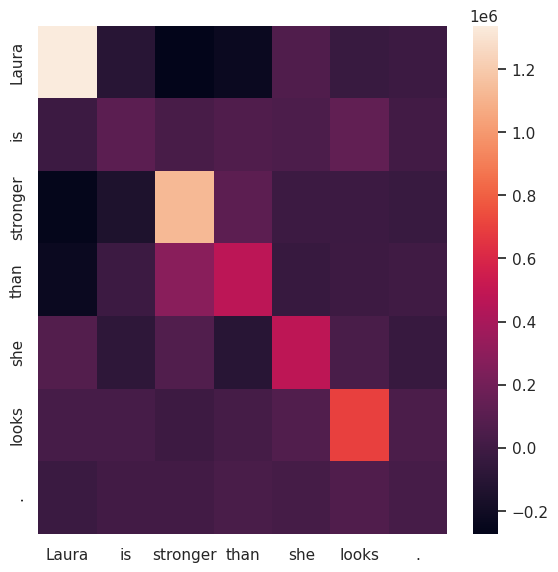

In [9]:
visualizer.visualize(text, scale = 0.2)

In [10]:
class CrossAttentionVisualizer(AttentionVisualizer):
    def __init__(self, model, tokenizer, **kwargs):
        super().__init__(model, tokenizer, **kwargs)
        self.get_layers_t5()
    
    def get_layers_t5(self):
        self.encoder = self.model.encoder
        self.decoder_embedding_layer = self.model.decoder.embed_tokens
        self.decoder_self_attn = self.model.decoder.block[0].layer[0]
        self.enc_dec_attn = self.model.decoder.block[0].layer[1].EncDecAttention
        self.q_w = self.enc_dec_attn.q
        self.k_w = self.enc_dec_attn.k

    def get_qk(self, encoder_input_ids, decoder_input_ids):
        encoder_output = self.encoder(en_input_ids)[0]
        decoder_embedding = self.decoder_embedding_layer(decoder_input_ids)
        decoder_embedding = self.decoder_self_attn(decoder_embedding)
        query = self.q_w(decoder_embedding[0]).squeeze(0)
        key = self.k_w(encoder_output).squeeze(0)
        print(query.size(), key.size())
        return torch.mm(query, key.T)[:-1, :-1]

    def visualize(self, input_text, output_text, scale = 0.3):
        encoder_tokens, encoder_input_ids = self.tokenize(input_text)
        decoder_tokens, decoder_input_ids = self.tokenize(output_text)
        scores = self.get_qk(encoder_input_ids, decoder_input_ids)
        height = len(input_text) * scale
        width = len(output_text) * scale
        draw_heatmap(scores.detach().numpy(), encoder_tokens, yticklabels = decoder_tokens, height = height, width = width)

In [11]:
visualizer = CrossAttentionVisualizer(model, tokenizer)

In [12]:
en_text = "Hello, how are you today?"
fr_text = "Bonjour, comment allez-vous aujourd'hui ?"

In [13]:
visualizer.visualize(en_text, fr_text)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 visualizer.visualize(en_text, fr_text)                                                       │
│   2                                                                                              │
│                                                                                                  │
│ in visualize:26                                                                                  │
│                                                                                                  │
│   23 │   def visualize(self, input_text, output_text, scale = 0.3):                              │
│   24 │   │   encoder_tokens, encoder_input_ids = self.tokenize(input_text)                       │
│   25 │   │   decoder_tokens, decoder_input_ids = self.tokenize(output_text)                      │
│ ❱ 26 │   │   scores = self.get_qk(encoder_input_ids, decoder_input_ids)                          │
│   27 │   │   height = len(input_text) * scale                                                    │
│   28 │   │   width = len(output_text) * scale                                                    │
│   29 │   │   draw_heatmap(scores.detach().numpy(), encoder_tokens, yticklabels = decoder_toke    │
│                                                                                                  │
│ in get_qk:15                                                                                     │
│                                                                                                  │
│   12 │   │   self.k_w = self.enc_dec_attn.k                                                      │
│   13 │                                                                                           │
│   14 │   def get_qk(self, encoder_input_ids, decoder_input_ids):                                 │
│ ❱ 15 │   │   encoder_output = self.encoder(en_input_ids)[0]                                      │
│   16 │   │   decoder_embedding = self.decoder_embedding_layer(decoder_input_ids)                 │
│   17 │   │   decoder_embedding = self.decoder_self_attn(decoder_embedding)                       │
│   18 │   │   query = self.q_w(decoder_embedding[0]).squeeze(0)                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'en_input_ids' is not defined